## Example 10-3 - Picking the correct rate law for the hydrogenation of ethylene

The reaction we are considering is a classic reaction:

$$H_2 + C_2H_4 \rightarrow C_2H_6$$

The reaction is carried out over a heterogeneous cobalt molybdenum catalyst, and the following rate data have been collected:

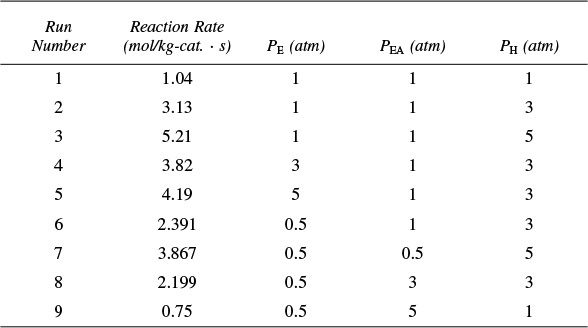

In [1]:
#Import our usual packages
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [161]:
#We'll also need some stats for calculating 95% confidence intervals
from scipy.stats.distributions import  t

In [30]:
#We'll need the curvefit function for fitting
from scipy.optimize import curve_fit

### Importing data from .xlsx files with pandas 
Sometimes the best way to enter large datasets is to use a GUI like Excel, and then import the data into numpy arrays. One particular good package for doing this is the **pandas** package

In [4]:
import pandas as pd #import the pandas package
df = pd.read_excel('10-3_data.xlsx') #import the Excel file into a pandas 'data frame'. Note, make sure the file you are trying to import is in the same folder as your notebook!

Pandas DataFrames are incredibly useful objects for storing heterogeneous tabular data. More information is available in the documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

For now, a few key methods:

In [5]:
df #Show the whole table. Note how it has realized that there are headings to each column

,Run Number,Reaction Rate,PE,PEA,PH
0,1,1.040,1.0,1.0,1
1,2,3.130,1.0,1.0,3
2,3,5.210,1.0,1.0,5
3,4,3.820,3.0,1.0,3
4,5,4.190,5.0,1.0,3
5,6,2.391,0.5,1.0,3
6,7,3.867,0.5,0.3,5
7,8,2.199,0.5,3.0,3
8,9,0.750,0.5,5.0,1


In [6]:
df.dtypes #List the datatypes associated with each column

Run Number         int64
Reaction Rate    float64
PE               float64
PEA              float64
PH                 int64
dtype: object

In [7]:
df.columns

Index(['Run Number', 'Reaction Rate', 'PE', 'PEA', 'PH'], dtype='object')

In [8]:
df.columns[1]

'Reaction Rate'

In [13]:
npdata = df.values #Return a numpy representation of the DataFrame. Very useful for when we start processing the data
npdata

array([[1.   , 1.04 , 1.   , 1.   , 1.   ],
       [2.   , 3.13 , 1.   , 1.   , 3.   ],
       [3.   , 5.21 , 1.   , 1.   , 5.   ],
       [4.   , 3.82 , 3.   , 1.   , 3.   ],
       [5.   , 4.19 , 5.   , 1.   , 3.   ],
       [6.   , 2.391, 0.5  , 1.   , 3.   ],
       [7.   , 3.867, 0.5  , 0.3  , 5.   ],
       [8.   , 2.199, 0.5  , 3.   , 3.   ],
       [9.   , 0.75 , 0.5  , 5.   , 1.   ]])

In [81]:
#Extract the data into individual np arrays
trial = npdata[:,0]
rate = npdata[:,1]
P_E = npdata[:,2]
P_EA = npdata[:,3]
P_H = npdata[:,4]
P = npdata[:,2:5]

## Plot the data
ALWAYS recommended, to see if you can spot any particular patterns emerging right away

Text(0, 0.5, 'Rate')

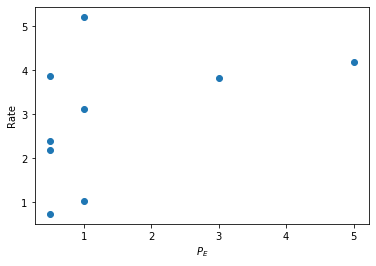

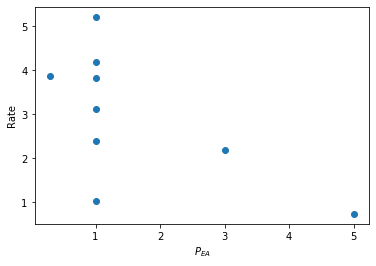

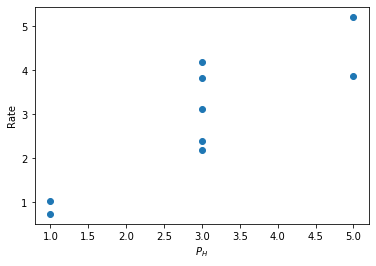

In [23]:
#Plot the data
plt.figure()
plt.scatter(P_E, rate)
plt.xlabel(r'$P_E$')
plt.ylabel('Rate')

plt.figure()
plt.scatter(P_EA, rate)
plt.xlabel(r'$P_{EA}$')
plt.ylabel('Rate')

plt.figure()
plt.scatter(P_H, rate)
plt.xlabel(r'$P_H$')
plt.ylabel('Rate')

## Fit parameters to each of four proposed rate laws
1. $$-r'_E = \frac{kP_EP_H}{1+K_{EA}P_{EA}+K_EP_E}$$
 
 
2. $$-r'_E = \frac{kP_EP_H}{1+K_EP_E}$$
 
 
3. $$-r'_E = \frac{kP_EP_H}{\left ( 1+K_EP_E \right ) ^2}$$


4. $$-r'_E = kP_E^aP_H^b$$

In [148]:
#Define each rate law as a function
def r1(P, k, K_E, K_EA):
    #k, K_E, K_EA = params
    P_E = P[:,0]
    P_EA = P[:,1]
    P_H = P[:,2] #unpack x data
    rE = k*P_E*P_H / (1. + K_EA*P_EA + K_E*P_E)
    return rE

def r2(P, k, K_E):
    #k, K_E = params
    P_E = P[:,0]
    P_EA = P[:,1]
    P_H = P[:,2] #unpack x data
    rE = k*P_E*P_H / (1 + K_E*P_E)
    return rE

def r3(P, k, K_E):
    #k, K_E = params
    P_E = P[:,0]
    P_EA = P[:,1]
    P_H = P[:,2] #unpack x data
    rE = k*P_E*P_H / (1 + K_E*P_E)**2
    return rE   

def r4(P, k, a, b):
    #k, a, b = params
    P_E = P[:,0]
    P_EA = P[:,1]
    P_H = P[:,2] #unpack x data
    rE = k*(P_E**a)*(P_H**b)
    return rE

rate_laws = [r1, r2, r3, r4] #Store a list of functions so that we can quickly iterate over them when fitting data

In [159]:
#Since each of our rate laws requires different number of parameters, we need to keep track of that when doing the fitting
#We can use inspect.signature to get details about the number of parameters a function requires
from inspect import signature #Import necessary package

for func in rate_laws:
    sig = signature(func) #Get signature of r1
    pr = sig.parameters #Get the parameters of that function
    print('Function ', str(func), ' requires ', len(pr), ' arguments') #Prints the total number of required arguments for any of the functions above. 

Function  <function r1 at 0x00000225FF7E44C8>  requires  4  arguments
Function  <function r2 at 0x00000225FF7E40D8>  requires  3  arguments
Function  <function r3 at 0x00000225FF9EC678>  requires  3  arguments
Function  <function r4 at 0x00000225FF9EC828>  requires  4  arguments


Text(0, 0.5, 'Rate')

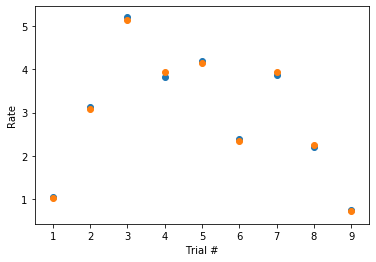

In [193]:
#Test script on a single function
p0_test = [0.1, 0.1, 0.1] #Provide an initial guess
popt1, pcov1 = curve_fit(r1, P, rate, p0 = p0_test) #Use curvefit to optimize parameters
r1_fit = r1(P, *popt1) #Calculate the model predictions to plot against the true data
plt.scatter(trial, rate, label = 'Experiment')
plt.scatter(trial, r1_fit, label = 'Model')
plt.xlabel('Trial #')
plt.ylabel('Rate')

Now that we've done this for one of the rate laws, let's do it for all of them. The code speeds things up by looping over a list of each of the rate laws that we want to test, rather than doing them individually. It stores the optimal parameters for all the fits (fit_params), as well as the covariance matrices (fit_cov) and the sum squared error (fit_sse) for each model. Finally, it spits out the 95% confidence interval for each estimated parameter, and plots of the fit vs. real data

Rate Law  <function r1 at 0x00000225FF7E44C8> :
parameter k:	 3.311 [2.941-3.680]
parameter K_E:	 2.184 [1.877-2.492]
parameter K_EA:	 0.036 [-0.031-0.103]
Sum squared error: 0.032

Rate Law  <function r2 at 0x00000225FF7E40D8> :
parameter k:	 3.187 [2.899-3.475]
parameter K_E:	 2.101 [1.837-2.365]
Sum squared error: 0.042

Rate Law  <function r3 at 0x00000225FF9EC678> :
parameter k:	 2.009 [1.743-2.275]
parameter K_E:	 0.362 [0.299-0.424]
Sum squared error: 0.436

Rate Law  <function r4 at 0x00000225FF9EC828> :
parameter k:	 0.894 [0.637-1.151]
parameter a:	 0.258 [0.188-0.329]
parameter b:	 1.062 [0.852-1.271]
Sum squared error: 0.297



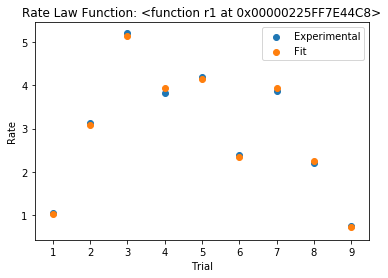

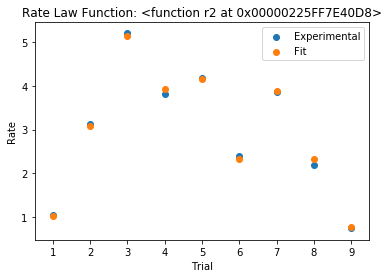

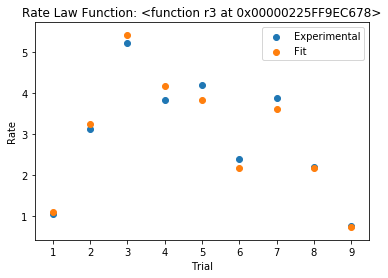

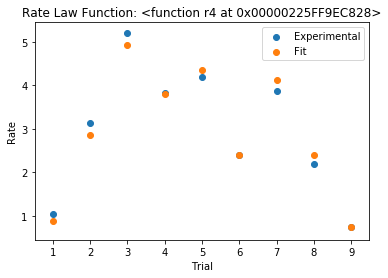

In [192]:
#Initialize lists to store the fit data
fit_params = []
fit_cov = []
fit_sse = []

#Statistical parameters
alpha = 0.05

for func in rate_laws:
    sig = signature(func)
    pr = sig.parameters
    param_guess = [0.10]*(len(pr)-1) #Set up an array of initial parameter estimate
    
    popt, pcov = curve_fit(func, P, rate, p0 = param_guess) #Calculate fit and covariance matrix

    #store the data
    fit_params.append(popt)
    fit_cov.append(pcov)
    
    #generate fit data
    fit = func(P, *popt) 
    
    #calculate sum square error
    sse = np.sum((fit-rate)**2)
    fit_sse.append(sse)
    
    #Plot the data
    plt.figure()
    plt.scatter(trial, rate, label = 'Experimental')
    plt.scatter(trial, fit, label = 'Fit')
    plt.xlabel('Trial')
    plt.ylabel('Rate')
    plt.title('Rate Law Function: '+str(func))
    plt.legend()
    
    #Calculate confidence intervals on the paramaeters and print them out for each function
    #Borrowed from here: http://kitchingroup.cheme.cmu.edu/blog/2013/02/18/Nonlinear-curve-fitting-with-confidence-intervals/
    n = len(trial)
    p = len(popt)
    dof = max(0, n-p) #Degrees of freedom
    tval = t.ppf(1.0-alpha/2.0, dof) #T-test for dof and confidence interval


    #Generate list of parameter names for each function
    param_names = []
    for param in pr:
        param_names.append(str(param))
    
    print('Rate Law ', str(func), ':')
    for i, p, var in zip(param_names[1:], popt, np.diag(pcov)):
        sigma = var**0.5
        print(f'parameter {i}:\t {p:.3f} [{p-sigma*tval:.3f}-{p+sigma*tval:.3f}]')
    print(f'Sum squared error: {sse:.3f}')
    print('')

## F-test
One way to compare two models who differ in the number of fitted parameters is the F-test. This test is based on the idea that, if the simpler model (e.g. fewer parameters) is correct, then the relative increase in sum of squares going from the more complicated to the simpler model is expected to equal the relative increase in degrees of freedom. Let model 1 be the simpler model, and model 2 be the more complicated model. Then:

$$F = \frac{(SS1-SS2)}{SS2} \frac{DF1-DF2}{DF2}$$

The F-test is a hypothesis test, with the null hypothesis that the simple model is correct. We reject that hypothesis if F is large (or it has a small p-value associated with it)

We can only do this test for Models 1 and 2, in this case.

In [206]:
SS1 = fit_sse[1] #Second model is the simpler
#print(SS1)
SS2 = fit_sse[0] #First model is the more complex
#print(SS2)
DF1 = len(trial)-(len(fit_params[1])-1)
DF2 = len(trial)-(len(fit_params[0])-1)
F = (SS1-SS2) / SS2 * (DF1-DF2) / DF2
print(F)

0.04237352491393186
0.03162751956177379
0.04853822376865432


Since F is small, there is no reason to reject the null hypothesis, and we can say that the more complex model is no better than the simpler model